# AGRUPAMIENTO (CLUSTERING)


GRUPO 04 - Integrantes:
*    Agustin Braida
*    Ignacio Carrera
*    Matias Etchegoyen
*    Agustin Trombetta
*    Tomas Ghiglione

# Exploración inicial

## Carga de datos

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

import sklearn.preprocessing as skp

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

pd.options.display.max_columns = None

from sklearn.metrics import silhouette_score, silhouette_samples


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
path = '/content/drive/MyDrive/Ciencia de datos/tp1/playlist_spotify.csv'
df = pd.read_csv(path)
df_base = df.copy(deep=True)
playlist_spotify = df

In [4]:
playlist_spotify.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.713,0.514,100125,0.521,0.816000,8,0.1120,-14.835,0,0.0444,119.879,4,0.143
1,0.192,0.714,207019,0.614,0.000000,4,0.2630,-6.935,1,0.0319,123.969,4,0.582
2,0.333,0.630,216200,0.455,0.000004,5,0.1270,-9.290,1,0.0292,139.931,4,0.199
3,0.601,0.810,136413,0.221,0.210000,5,0.1840,-11.005,1,0.0429,109.960,4,0.798
4,0.883,0.465,181440,0.459,0.000173,6,0.0692,-8.137,0,0.0351,90.807,4,0.288


In [5]:
spo = playlist_spotify.copy()

## Distribución de Variables

In [6]:
print(f"Dimensiones del dataset: {playlist_spotify.shape}")
print(playlist_spotify.info())

Dimensiones del dataset: (750, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      750 non-null    float64
 1   danceability      750 non-null    float64
 2   duration          750 non-null    int64  
 3   energy            750 non-null    float64
 4   instrumentalness  750 non-null    float64
 5   key               750 non-null    int64  
 6   liveness          750 non-null    float64
 7   loudness          750 non-null    float64
 8   mode              750 non-null    int64  
 9   speechiness       750 non-null    float64
 10  tempo             750 non-null    float64
 11  time_signature    750 non-null    int64  
 12  valence           750 non-null    float64
dtypes: float64(9), int64(4)
memory usage: 76.3 KB
None


Todos los valores son numéricos

In [7]:
null_counts = playlist_spotify.isna().sum()
print(null_counts)

acousticness        0
danceability        0
duration            0
energy              0
instrumentalness    0
key                 0
liveness            0
loudness            0
mode                0
speechiness         0
tempo               0
time_signature      0
valence             0
dtype: int64


Sin valores faltantes en el dataset

### Histograma para cada variable:

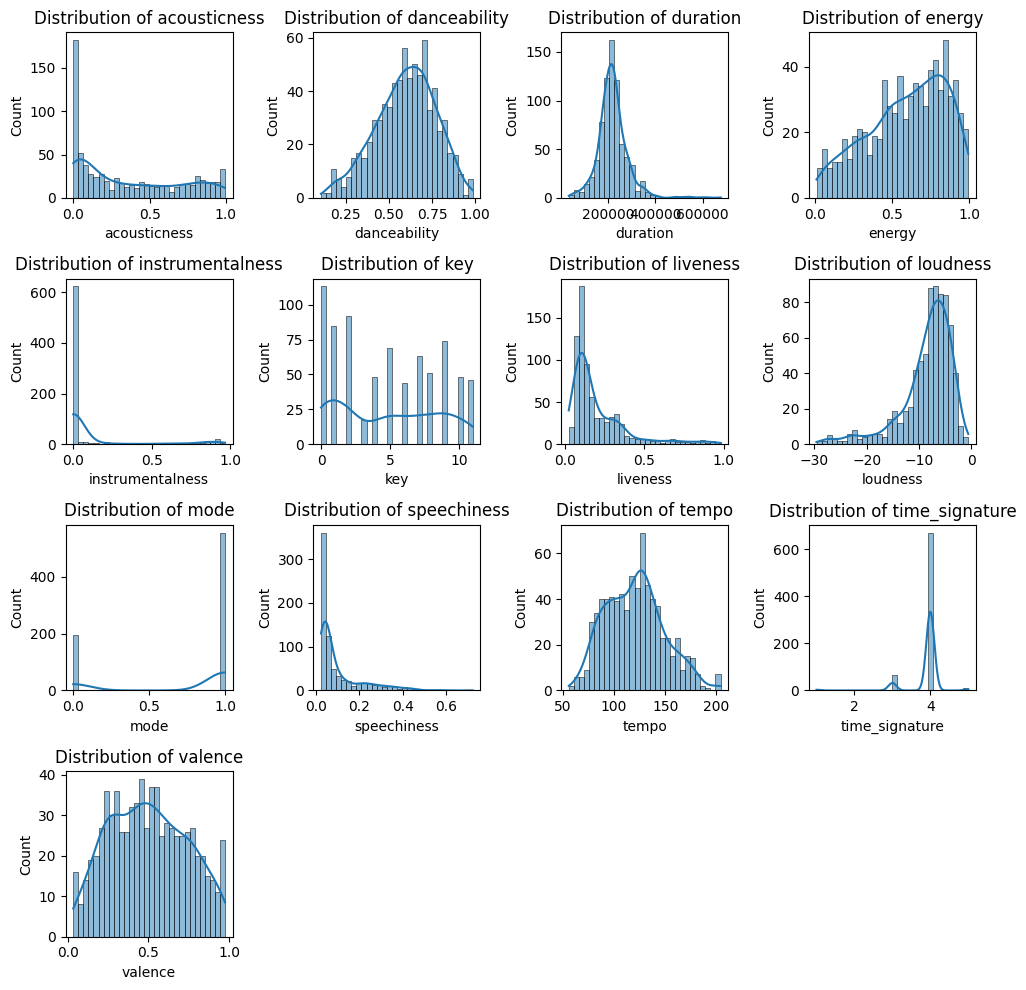

In [8]:
n_cols = 4
n_rows = (len(playlist_spotify.columns) // n_cols + 1)

plt.figure(figsize=(10, 2.5 * n_rows))
for i, column in enumerate(playlist_spotify.columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(playlist_spotify[column], kde=True, bins=30)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

### BoxPlot para cada variable

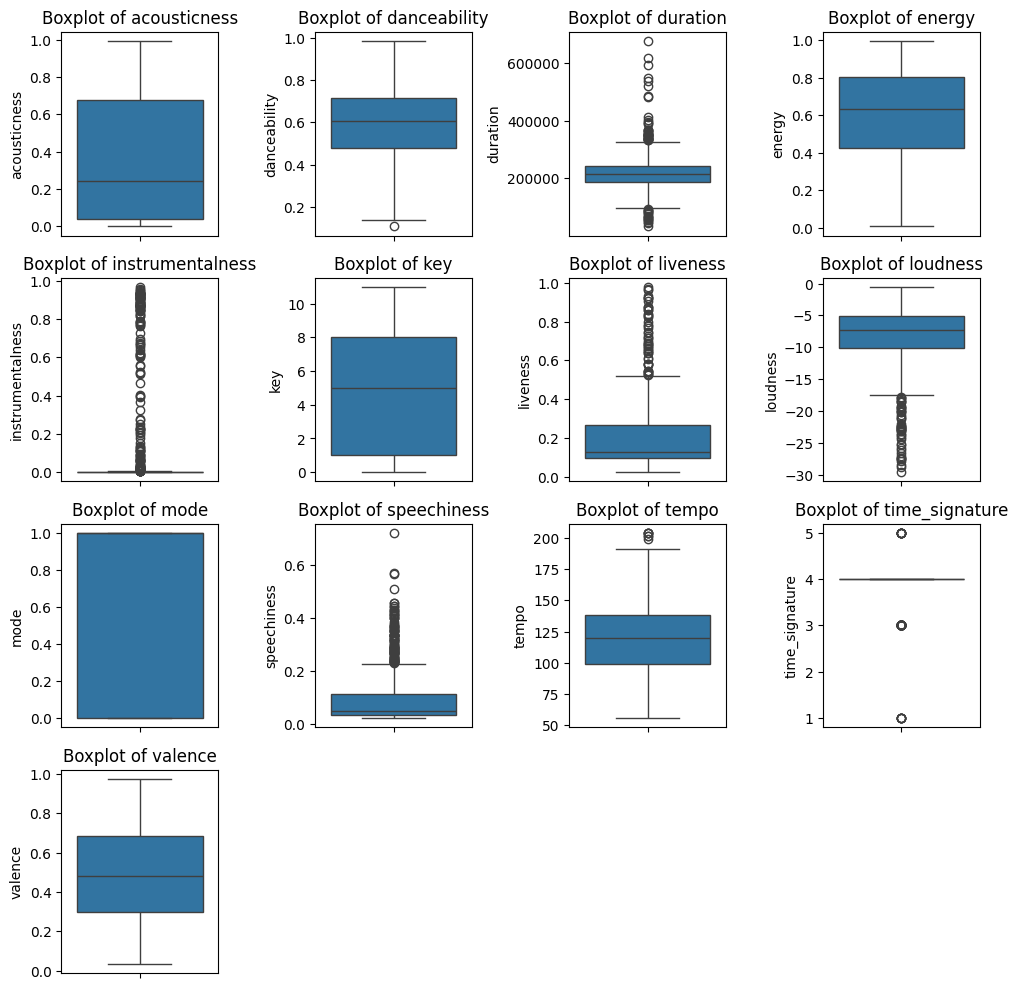

In [9]:
n_cols = 4
n_rows = (len(playlist_spotify.columns) // n_cols + 1)

plt.figure(figsize=(10, 2.5 * n_rows))
for i, column in enumerate(playlist_spotify.columns,1):
    plt.subplot(n_rows, n_cols,i)
    sns.boxplot(y=playlist_spotify[column])
    plt.title(f'Boxplot of {column}')
plt.tight_layout()
plt.show()

## Analisis de correlación

### Matriz de correlación

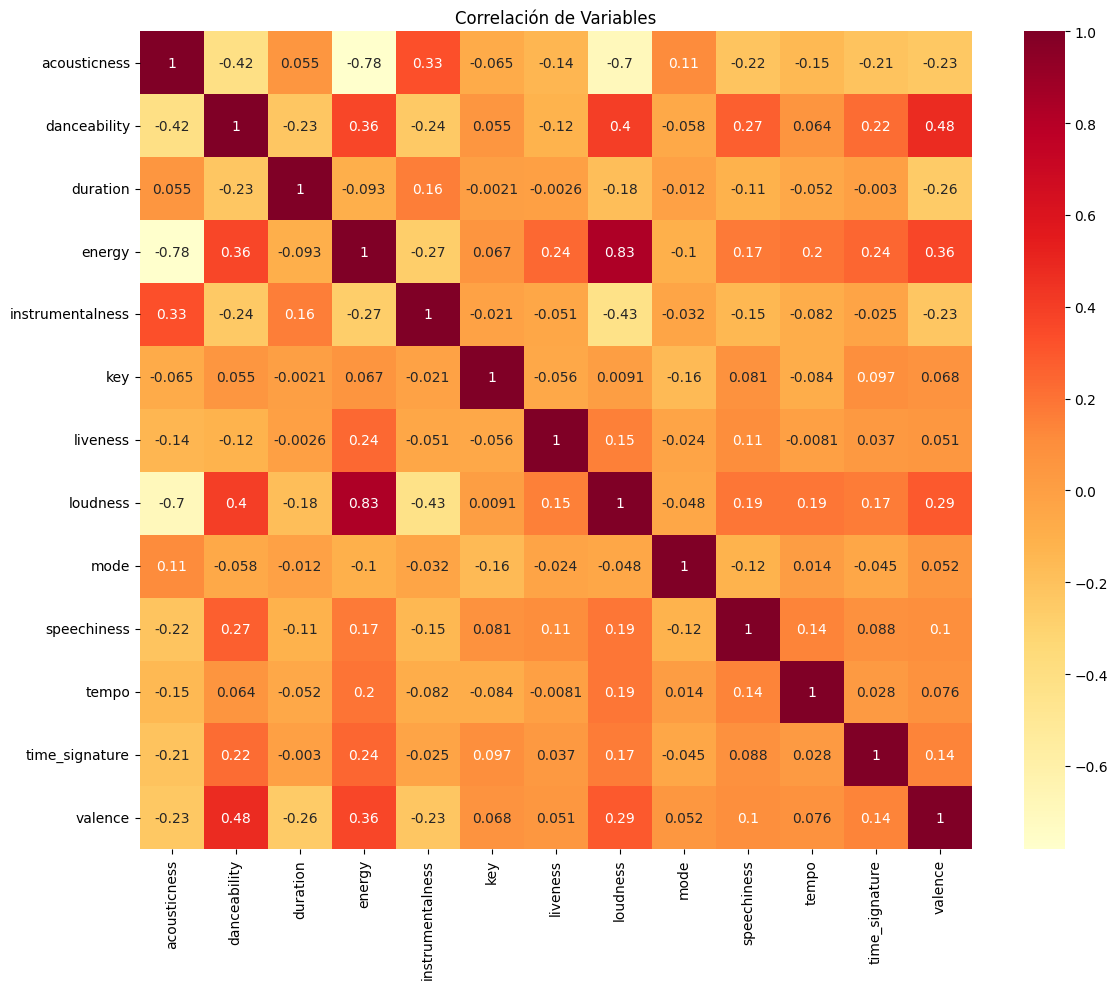

In [10]:
correlation_matrix = spo.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlación de Variables')
plt.tight_layout()
plt.show()

### Pairplot

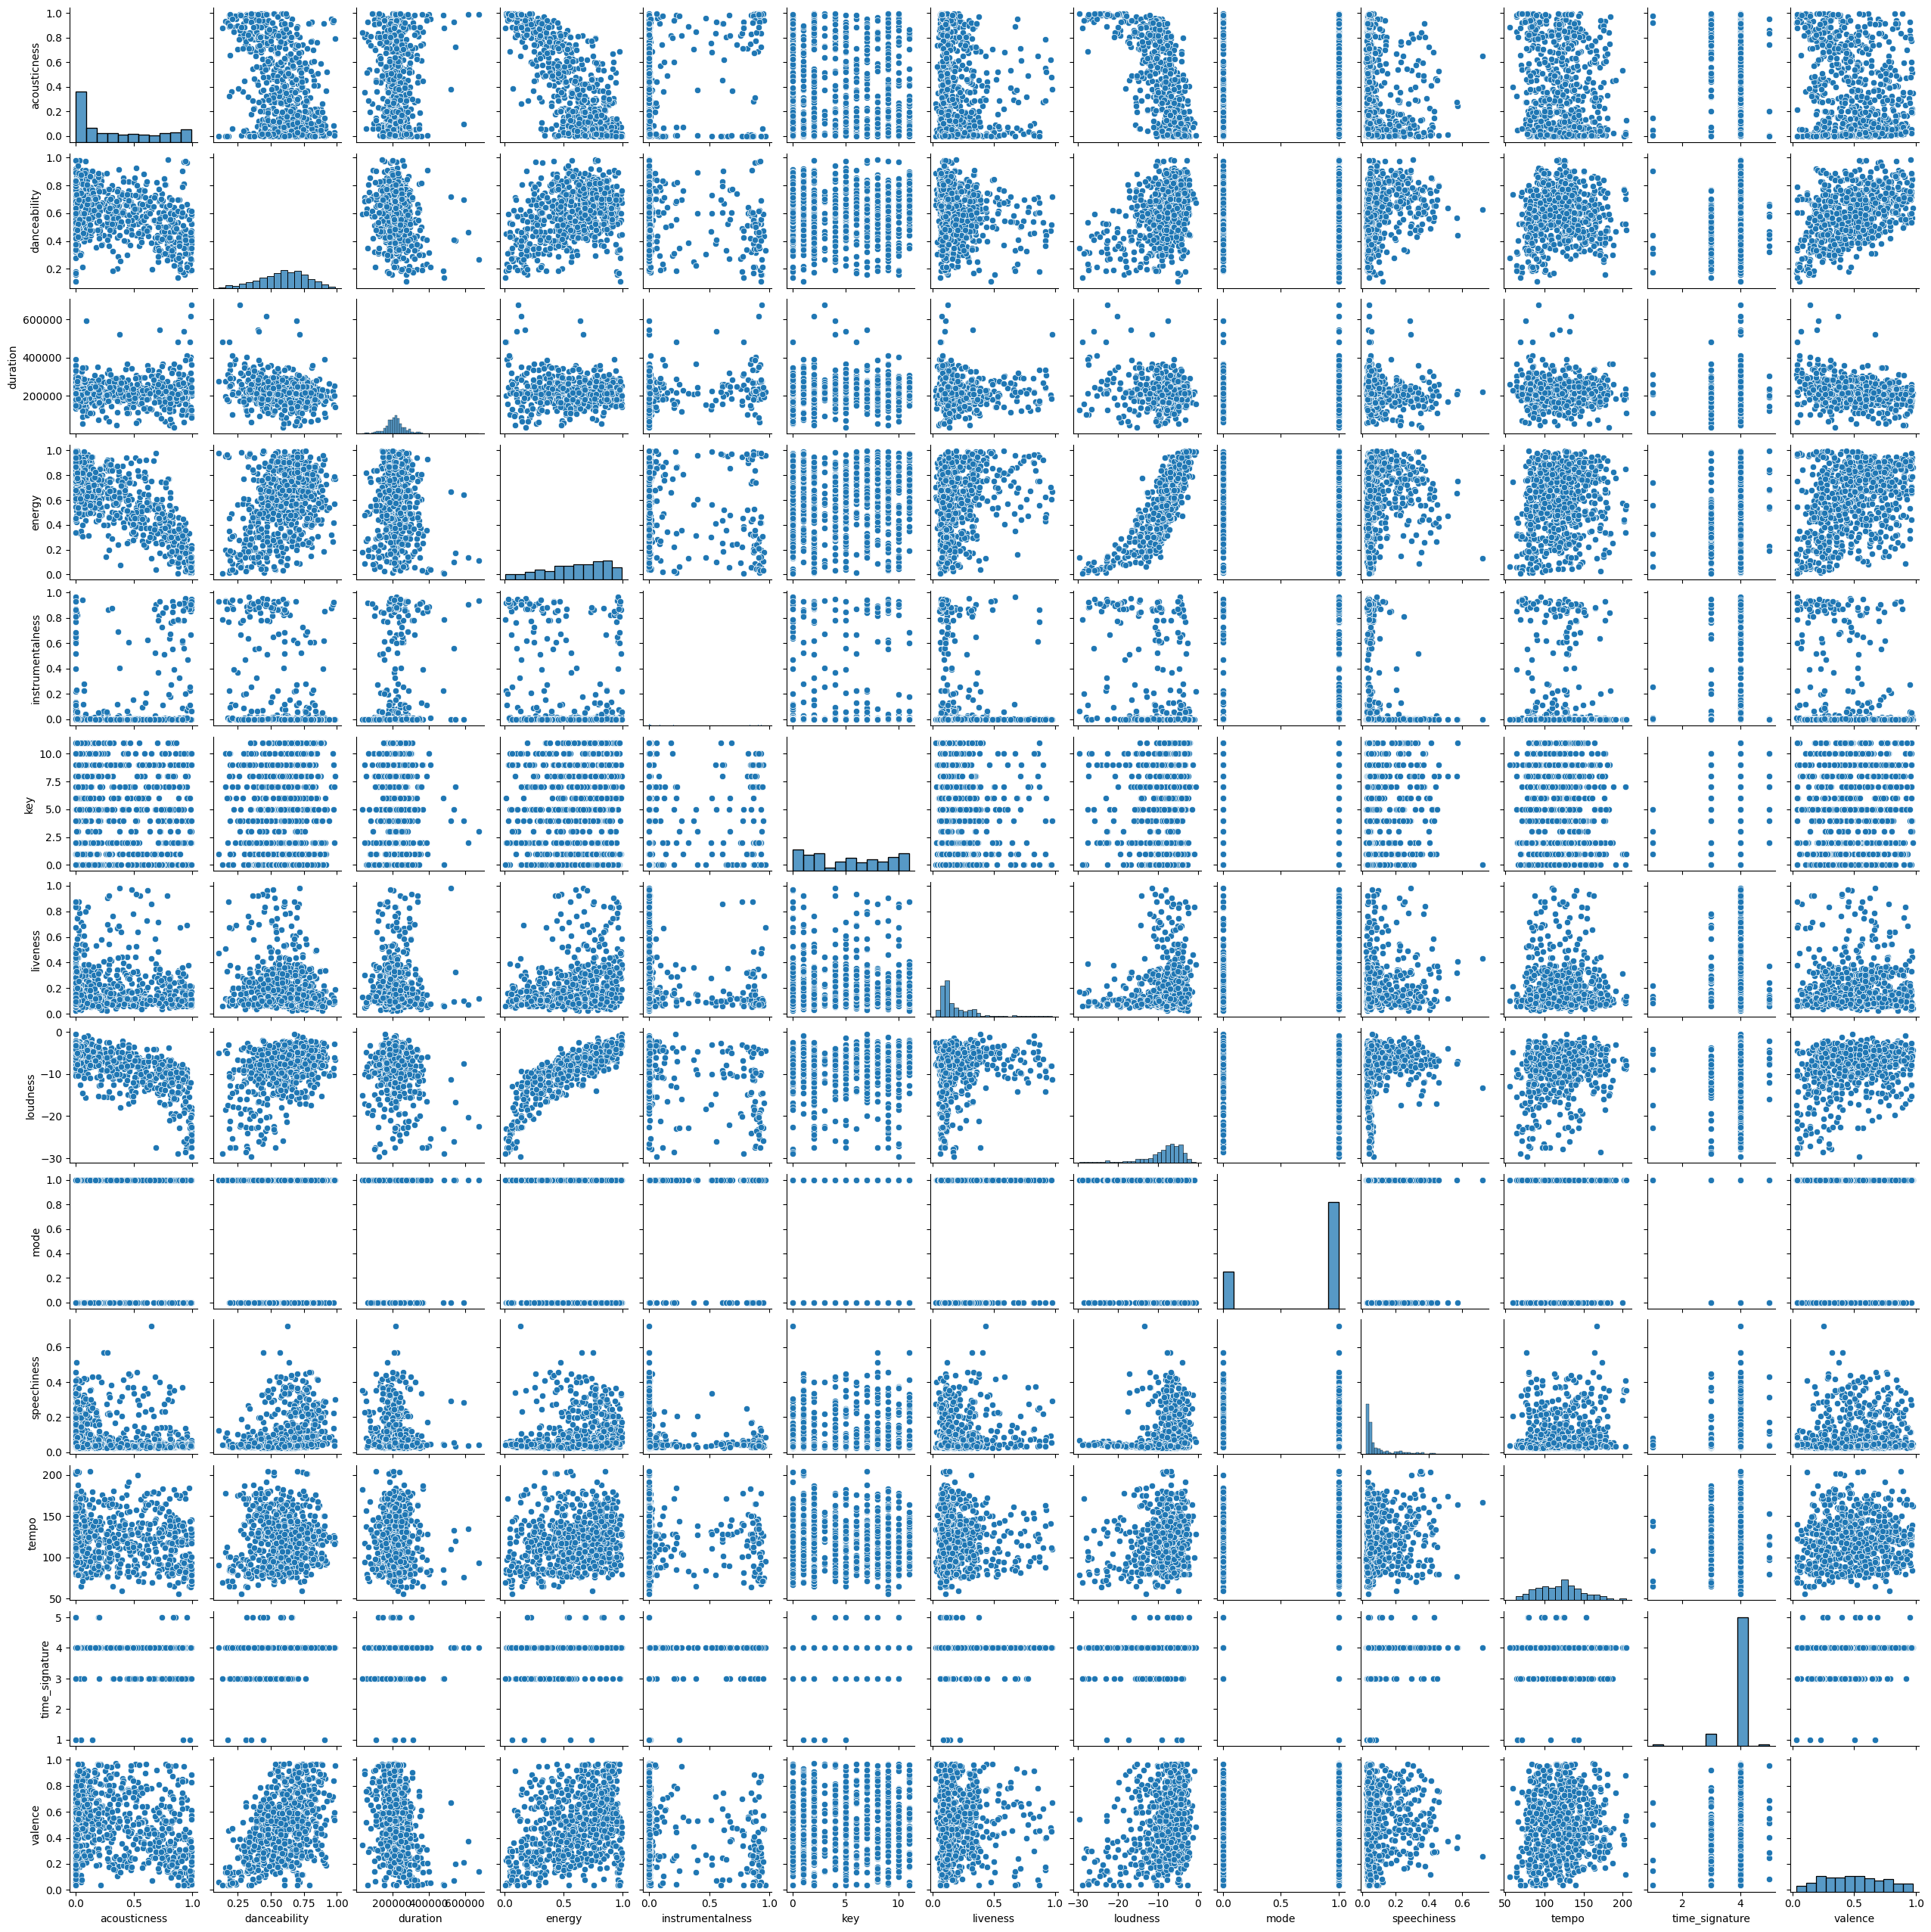

In [11]:
sns.pairplot(spo, height=2)

### Variables altamente correlacionadas

In [12]:
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i],
                                  correlation_matrix.columns[j],
                                  correlation_matrix.iloc[i, j]))

print("Pares de variables altamente correlacionadas:")
for var1, var2, corr in high_corr_pairs:
    print(f"{var1} - {var2}: {corr:.3f}")

Pares de variables altamente correlacionadas:
acousticness - energy: -0.782
energy - loudness: 0.830


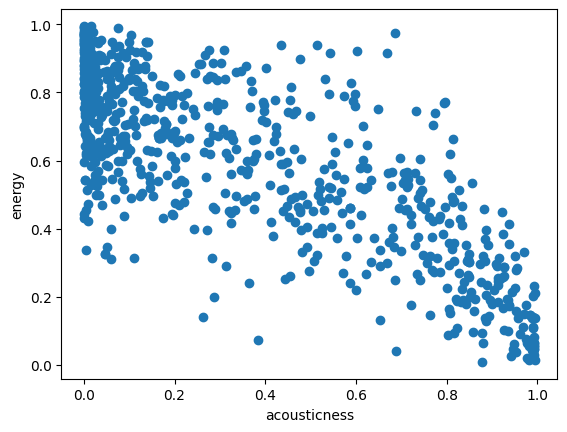

In [13]:
plt.scatter(spo['acousticness'], spo['energy'])
plt.xlabel('acousticness')
plt.ylabel('energy')
plt.show()

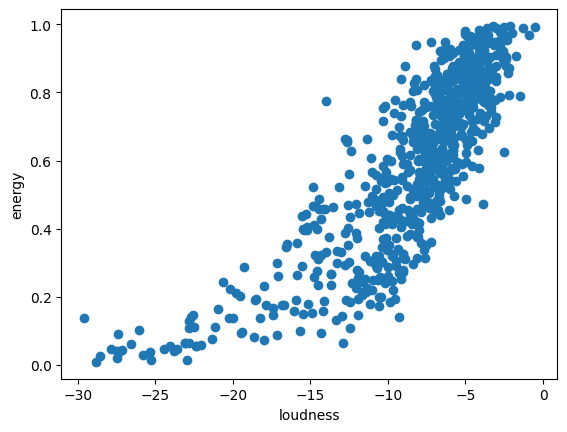

In [14]:
plt.scatter(spo['loudness'], spo['energy'])
plt.xlabel('loudness')
plt.ylabel('energy')
plt.show()

## Analisis de outliers

### Univariado

In [15]:
def detect_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)][column]
    return outliers

In [16]:
for feature in playlist_spotify.columns:
    outliers = detect_outliers(playlist_spotify, feature)
    print(f"Posibles outliers en {feature}: {len(outliers)} ({len(outliers)/len(playlist_spotify)*100:.2f}%)")

Posibles outliers en acousticness: 0 (0.00%)
Posibles outliers en danceability: 1 (0.13%)
Posibles outliers en duration: 53 (7.07%)
Posibles outliers en energy: 0 (0.00%)
Posibles outliers en instrumentalness: 162 (21.60%)
Posibles outliers en key: 0 (0.00%)
Posibles outliers en liveness: 51 (6.80%)
Posibles outliers en loudness: 49 (6.53%)
Posibles outliers en mode: 0 (0.00%)
Posibles outliers en speechiness: 96 (12.80%)
Posibles outliers en tempo: 7 (0.93%)
Posibles outliers en time_signature: 79 (10.53%)
Posibles outliers en valence: 0 (0.00%)


In [17]:
def detect_outliers_row(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_df = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers_df

In [18]:
outlier_rows = detect_outliers_row(playlist_spotify, 'danceability')
outlier_rows

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
604,0.000003,0.107,277012,0.979,0.93,1,0.475,-5.031,1,0.124,91.066,4,0.0571


In [19]:
Q1 = playlist_spotify['danceability'].quantile(0.25)
Q3 = playlist_spotify['danceability'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
print(f"Limite inferior (moderado): {lower_bound}")

Limite inferior (moderado): 0.12637499999999996


In [20]:
low_values = playlist_spotify[playlist_spotify['danceability'] < lower_bound]
print(f"Cantidad de danceability tracks bajos: {len(low_values)}")

Cantidad de danceability tracks bajos: 1


Se decide elminarlo. Es un posible ruido.

In [21]:
spo = spo[spo['danceability'] > lower_bound]

In [22]:
outlier_rows_duration = detect_outliers_row(playlist_spotify, 'duration')
outlier_rows_duration.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
8,0.748,0.420,366179,0.3240,0.839,9,0.0723,-14.700,0,0.0556,183.020,3,0.330
22,0.615,0.499,361613,0.6030,0.000,7,0.2080,-10.022,1,0.3350,128.317,4,0.417
45,0.263,0.579,86813,0.1410,0.000,0,0.2960,-9.288,1,0.1050,128.824,4,0.737
47,0.988,0.318,403280,0.0451,0.888,10,0.0769,-27.127,1,0.0483,79.544,4,0.142
68,0.379,0.719,520661,0.6640,0.000,4,0.9790,-11.361,0,0.2910,109.544,4,0.672


In [23]:
filter_short = 60000 # Filter: 1 min
short_tracks = playlist_spotify[playlist_spotify['duration'] < filter_short]
print(f"Canciones menores a {filter_short}ms: {short_tracks.shape[0]}")
short_tracks

Canciones menores a 60000ms: 6


,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
215,0.803,0.715,46107,0.0882,0.0,9,0.0458,-17.133,1,0.3380,94.622,4,0.917
351,0.826,0.695,55653,0.2710,0.0,0,0.0591,-9.283,1,0.2940,137.503,3,0.519
449,0.517,0.631,58671,0.5000,0.0,0,0.0799,-8.154,1,0.0290,79.969,3,0.694
488,0.843,0.592,33840,0.1800,0.0,5,0.1310,-15.150,1,0.3530,182.250,3,0.346
651,0.059,0.597,56331,0.8180,0.0,8,0.0905,-4.910,1,0.0812,156.922,4,0.758
700,0.353,0.685,48093,0.4810,0.0,2,0.3040,-10.013,1,0.2280,116.888,4,0.893


In [24]:
filter_long = 600000  # Filter: 10 mins
long_tracks = playlist_spotify[playlist_spotify['duration'] > filter_long ]
print(f"Canciones mayores a {filter_long}ms: {long_tracks.shape[0]}")
long_tracks

Canciones mayores a 600000ms: 2


,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
241,0.990,0.268,675360,0.113,0.934,3,0.1210,-22.509,1,0.0417,92.943,4,0.142
730,0.987,0.464,618400,0.139,0.908,2,0.0696,-20.210,1,0.0393,134.537,4,0.372


In [25]:
filter_longer = 900000 # Filter: 15 mins
longer = playlist_spotify[playlist_spotify['duration'] > filter_longer ]
longer_count = longer.shape[0]

filter_shorter = 30000 # Filter: 30 sec
shorter = playlist_spotify[playlist_spotify['duration'] < filter_shorter ]
shorter_count = shorter.shape[0]
print(f"Cantidad de tracks cortos (menos de {filter_shorter}ms): {shorter_count}")
print(f"Cantidad de tracks largos (mas de {filter_longer}ms): {longer_count}")

Cantidad de tracks cortos (menos de 30000ms): 0
Cantidad de tracks largos (mas de 900000ms): 0


No se consideran outliers en 'duration'.

In [26]:
outliers_liveness = detect_outliers_row(playlist_spotify, 'liveness')
print(f"Son {outliers_liveness.shape[0]} outliers")
outliers_liveness.head()

Son 51 outliers


,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
30,0.36000,0.201,262360,0.488,0.118000,0,0.666,-10.913,1,0.0284,88.582,4,0.1040
68,0.37900,0.719,520661,0.664,0.000000,4,0.979,-11.361,0,0.2910,109.544,4,0.6720
78,0.95300,0.237,203893,0.158,0.000223,6,0.692,-14.205,1,0.0337,100.122,3,0.0439
119,0.00427,0.597,171360,0.837,0.001140,10,0.839,-6.518,1,0.3750,126.342,4,0.4470
131,0.37300,0.653,174785,0.660,0.000000,6,0.684,-4.966,1,0.0511,87.958,4,0.6770


In [27]:
print(outliers_liveness['liveness'].sort_values(ascending=False))

68     0.979
455    0.970
132    0.966
281    0.931
271    0.924
421    0.922
618    0.922
453    0.905
438    0.875
678    0.874
425    0.873
183    0.860
150    0.858
119    0.839
310    0.832
600    0.831
538    0.825
500    0.797
227    0.785
637    0.778
236    0.765
133    0.748
159    0.744
217    0.725
552    0.718
137    0.716
495    0.700
78     0.692
178    0.684
131    0.684
498    0.675
266    0.673
30     0.666
467    0.659
174    0.651
263    0.651
623    0.637
663    0.636
594    0.611
237    0.610
188    0.584
727    0.583
643    0.583
486    0.579
223    0.546
508    0.546
529    0.542
490    0.540
586    0.531
355    0.528
249    0.527
Name: liveness, dtype: float64


Se decide cortar en *0.8* ya que no aportarán información importante y generará estabilidad a la hora de utilizar K-Means posteriormente. Son todos tracks que probablemente sean en vivo.

> Liveness:
Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.



In [28]:
spo['liveness'] = spo['liveness'].clip(upper=0.8)

<ipython-input-28-fdc405aa72a7>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spo['liveness'] = spo['liveness'].clip(upper=0.8)


In [29]:
outliers_liveness = detect_outliers_row(spo, 'liveness')
print(f"Ahora son {outliers_liveness.shape[0]} outliers")
outliers_liveness.head()

Ahora son 52 outliers


,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
30,0.36000,0.201,262360,0.488,0.118000,0,0.666,-10.913,1,0.0284,88.582,4,0.1040
68,0.37900,0.719,520661,0.664,0.000000,4,0.800,-11.361,0,0.2910,109.544,4,0.6720
78,0.95300,0.237,203893,0.158,0.000223,6,0.692,-14.205,1,0.0337,100.122,3,0.0439
119,0.00427,0.597,171360,0.837,0.001140,10,0.800,-6.518,1,0.3750,126.342,4,0.4470
131,0.37300,0.653,174785,0.660,0.000000,6,0.684,-4.966,1,0.0511,87.958,4,0.6770


In [30]:
median = outliers_liveness['liveness'].median()
min = outliers_liveness['liveness'].min()
max = outliers_liveness['liveness'].max()
print(f"Mediana: {median}")
print(f"Minimo: {min}")
print(f"Maximo: {max}")

Mediana: 0.708
Minimo: 0.519
Maximo: 0.8


In [31]:
borderline = outliers_liveness[outliers_liveness['liveness'].between(min, 0.8)]
borderline.shape[0]

52

In [32]:
playlist_spotify[playlist_spotify['liveness'].between(min, 0.8)].shape[0]

35

In [33]:
outlier_rows_loudness = detect_outliers_row(spo, 'loudness')
outlier_rows_loudness.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
18,0.992,0.525,226293,0.0633,0.905,9,0.1050,-23.072,1,0.0497,71.855,4,0.2970
25,0.994,0.450,199493,0.0153,0.919,2,0.0630,-25.257,1,0.0552,81.327,4,0.2260
32,0.983,0.311,124067,0.1470,0.000,10,0.1070,-22.533,1,0.0567,77.834,4,0.3870
35,0.962,0.211,103867,0.0904,0.881,8,0.1830,-27.385,1,0.0385,82.279,3,0.0652
47,0.988,0.318,403280,0.0451,0.888,10,0.0769,-27.127,1,0.0483,79.544,4,0.1420


Loudness:

> (...) Values typically range between -60 and 0 db



In [34]:
filter_max = 0
max_loudness = spo[spo['loudness'] > filter_max]
print(f"Tracks con loudness superior a {filter_max} db: {max_loudness.shape[0]}")

Tracks con loudness superior a 0 db: 0


In [35]:
filter_min = -60
min_loudness = spo[playlist_spotify['loudness'] < filter_min]
print(f"Tracks con loudness inferior a {filter_min} db: {min_loudness.shape[0]}")

Tracks con loudness inferior a -60 db: 0


<ipython-input-35-7de6307a1169>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  min_loudness = spo[playlist_spotify['loudness'] < filter_min]


In [36]:
outlier_rows_tempo = detect_outliers_row(spo, 'tempo')
outlier_rows_tempo

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
10,0.530000,0.525,206249,0.574,0.000007,1,0.3140,-6.448,0,0.2960,199.512,4,0.420
195,0.000146,0.774,181400,0.431,0.000020,1,0.1120,-8.407,1,0.3460,201.843,4,0.353
350,0.005820,0.743,238373,0.339,0.000000,1,0.0812,-7.678,1,0.4090,203.927,4,0.118
377,0.028300,0.522,191093,0.526,0.000376,0,0.1310,-8.790,1,0.0354,203.669,4,0.530
649,0.000107,0.766,181573,0.442,0.000061,1,0.1110,-8.558,1,0.3560,201.800,4,0.390
654,0.018500,0.703,207408,0.851,0.000244,7,0.1020,-6.813,1,0.3530,203.988,4,0.879
743,0.125000,0.480,110075,0.560,0.000000,1,0.1360,-7.868,1,0.3510,204.162,4,0.571


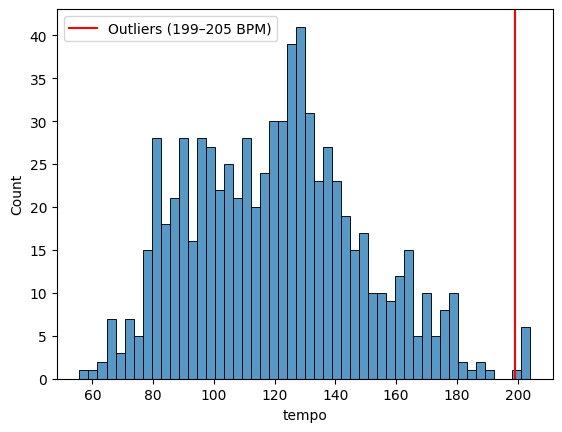

In [37]:
sns.histplot(spo['tempo'], bins=50)
plt.axvline(x=199, color='red', label='Outliers (199–205 BPM)')
plt.legend()

In [38]:
near_outliers = spo[(spo['tempo'] >= 180) & (spo['tempo'] < 199)]
print(f"Tracks entre 180–198 BPM: {len(near_outliers)}")

Tracks entre 180–198 BPM: 10


Picos aislados de `tempo` > 199. Se decide cortar en 180 BPM

In [39]:
# spo['tempo'] = spo['tempo'].clip(upper=180)

In [40]:
outlier_rows_time_signature = detect_outliers_row(spo, 'time_signature')
outlier_rows_time_signature.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
8,0.7480,0.420,366179,0.3240,0.839000,9,0.0723,-14.700,0,0.0556,183.020,3,0.3300
34,0.9510,0.662,206467,0.2270,0.000000,2,0.0613,-12.030,1,0.1080,116.003,5,0.6290
35,0.9620,0.211,103867,0.0904,0.881000,8,0.1830,-27.385,1,0.0385,82.279,3,0.0652
53,0.9340,0.580,187427,0.1010,0.000302,10,0.0768,-15.661,1,0.0289,91.003,3,0.3020
54,0.0469,0.311,208467,0.3250,0.000000,2,0.1390,-9.042,1,0.0283,65.090,1,0.6680


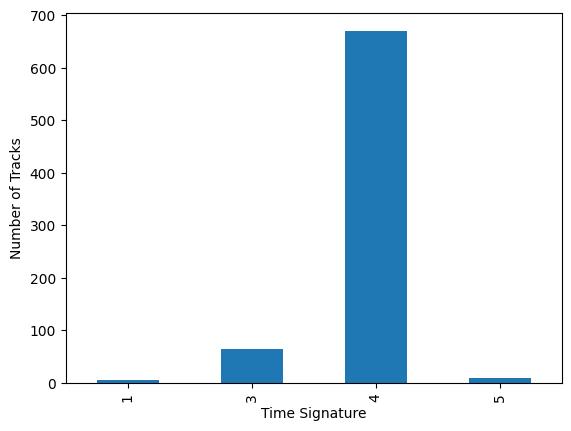

In [41]:
spo['time_signature'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Time Signature')
plt.ylabel('Number of Tracks')
plt.show()

time_signature:
> An estimated time signature. The time signature (meter) is a notational convention to specify how many beats are in each bar (or measure). The time signature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4"

In [42]:
playlist_spotify[playlist_spotify['time_signature'] == 1]

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
54,0.04690,0.311,208467,0.3250,0.00000,2,0.1390,-9.042,1,0.0283,65.090,1,0.6680
83,0.04690,0.311,208467,0.3250,0.00000,2,0.1390,-9.042,1,0.0283,65.090,1,0.6680
316,0.92300,0.173,312400,0.1670,0.01240,2,0.1100,-17.398,1,0.0409,71.746,1,0.0332
433,0.14400,0.904,111304,0.5550,0.00864,5,0.1150,-5.157,1,0.0820,138.084,1,0.5020
502,0.00216,0.442,215110,0.7390,0.00169,1,0.0854,-4.084,1,0.0598,108.288,1,0.2290
593,0.97700,0.350,261107,0.0652,0.25200,3,0.2190,-22.807,1,0.0431,144.171,1,0.1440


In [43]:
odd_tracks = spo[spo['time_signature'] == 1]
print(f"Cantidad de tracks con tempo = 1/4: {odd_tracks.shape[0]}")

Cantidad de tracks con tempo = 1/4: 6


Se decide elminarlos. No tienen sentido según la documentación del dataset.

In [44]:
spo = spo[spo['time_signature'] != 1]

In [45]:
outlier_rows_speechiness = detect_outliers_row(spo, 'speechiness')
outlier_rows_speechiness.shape[0]

95



> Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.



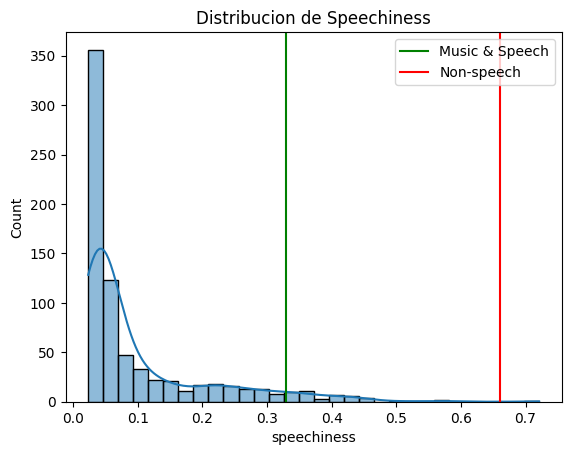

In [46]:
sns.histplot(spo['speechiness'], bins=30, kde=True)
plt.axvline(x=0.33, color='green', label='Music & Speech')
plt.axvline(x=0.66, color='red', label='Non-speech')
plt.legend()
plt.title('Distribucion de Speechiness')
plt.show()

Todo dentro de los valores aceptables.

In [47]:
median = spo['instrumentalness'].median()
print(f"Mediana: {median}")
min = spo['instrumentalness'].min()
print(f"Minimo: {min}")
max = spo['instrumentalness'].max()
print(f"Maximo: {max}")

Mediana: 1.02e-05
Minimo: 0.0
Maximo: 0.967


### Multivariado

In [48]:
def calculate_mahalanobis_distance(dataset, col1, col2, frac=1):
    X = dataset[[f'{col1}', f'{col2}']].copy()
    sample_X = X.sample(frac=frac)

    mu = sample_X.mean()
    X_diff = X - mu
    X_diff = X_diff.values.T

    cov = np.cov(sample_X.values.T)
    inv_cov = np.linalg.inv(cov)
    W = la.sqrtm(inv_cov)

    Wx = np.matmul(W, X_diff)
    X['mahalanobis'] = [np.dot(Wx[:, i], Wx[:, i]) for i in range(Wx.shape[1])]

    return X

In [49]:
vmedias = np.mean(spo[["loudness", "energy"]])

x_dif = spo[["loudness", "energy"]] - vmedias

cov = spo[["loudness", "energy"]].cov().values
inv_cov = np.linalg.inv(cov)

mahal = np.dot(np.dot(x_dif, inv_cov), x_dif.T)

# spo["mahalanobis"] = mahal.diagonal()

In [50]:
spo.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,0.713,0.514,100125,0.521,0.816000,8,0.1120,-14.835,0,0.0444,119.879,4,0.143
1,0.192,0.714,207019,0.614,0.000000,4,0.2630,-6.935,1,0.0319,123.969,4,0.582
2,0.333,0.630,216200,0.455,0.000004,5,0.1270,-9.290,1,0.0292,139.931,4,0.199
3,0.601,0.810,136413,0.221,0.210000,5,0.1840,-11.005,1,0.0429,109.960,4,0.798
4,0.883,0.465,181440,0.459,0.000173,6,0.0692,-8.137,0,0.0351,90.807,4,0.288


In [52]:
#sns.boxplot(y=spo.mahalanobis)

In [53]:
umbral_min = 939
umbral_max = 1300

In [54]:
#es_outlier = spo["mahalanobis"] > umbral_max

#sns.scatterplot(x=spo.loudness, y=spo.energy, hue=es_outlier)
#plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0, title="Outlier")
#plt.title("Dispersograma loudness vs energy")
#plt.show()

## Normalización de los datos

Se decide estandarizar los datos ya que K-Means utiliza distancias euclidianas. Variables con diferentes escalas podrían ensuciar el proceso de clustering

In [55]:
from sklearn.preprocessing import StandardScaler

In [56]:
scaler = StandardScaler()

X_scaled = scaler.fit_transform(spo)
X_scaled_df = pd.DataFrame(X_scaled, columns=spo.columns)

X_scaled_df.head()

,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,1.052543,-0.498223,-1.828268,-0.295496,2.766068,0.864454,-0.526596,-1.264559,-1.682230,-0.523277,-0.026240,0.243035,-1.490972
1,-0.491658,0.680149,-0.198541,0.073183,-0.384421,-0.234416,0.362530,0.310370,0.594449,-0.642308,0.118561,0.243035,0.348082
2,-0.073746,0.185233,-0.058565,-0.557139,-0.384407,0.040302,-0.438273,-0.159118,0.594449,-0.668019,0.683675,0.243035,-1.256378
3,0.720584,1.245767,-1.275014,-1.484784,0.426367,0.040302,-0.102642,-0.501017,0.594449,-0.537561,-0.377410,0.243035,1.252946
4,1.556409,-0.786924,-0.588523,-0.541282,-0.383753,0.315019,-0.778614,0.070742,-1.682230,-0.611836,-1.055497,0.243035,-0.883540


## Almacenamiento de los Datos Procesados

In [57]:
final_df = X_scaled_df.copy()

# Analisis de la tendencia al clustering

## Estadistica de Hopkins

In [58]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from numpy.random import uniform, randint
from sklearn.cluster import KMeans

In [59]:
def hopkins_statistic(X, sample_size=0.05, random_state=None):
    X = np.array(X)
    n = X.shape[0]
    d = X.shape[1]

    # Step 1: Generate uniform random sample
    X_uniform = uniform(np.min(X, axis=0), np.max(X, axis=0),
                       size=(int(sample_size * n), d))

    # Step 2: Randomly sample from original data
    np.random.seed(random_state)
    random_indices = randint(0, n, size=int(sample_size * n))
    X_sample = X[random_indices]

    # Step 3: Fit NearestNeighbors on original data
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)  # Only need 1 neighbor

    # Step 4: Distances for uniform sample (u_distances)
    u_distances, _ = nbrs.kneighbors(X_uniform, n_neighbors=1)
    u_sum = np.sum(u_distances)

    # Step 5: Distances for data sample (w_distances)
    w_distances, _ = nbrs.kneighbors(X_sample, n_neighbors=2)  # 2nd neighbor is the closest OTHER point
    w_sum = np.sum(w_distances[:, 1])  # Ignore the first neighbor (itself)

    # Step 6: Compute Hopkins Statistic
    H = u_sum / (u_sum + w_sum)
    return H

In [60]:
H = hopkins_statistic(final_df.values, sample_size=0.05, random_state=42)
print(f"Hopkins Statistic: {H}")

Hopkins Statistic: 0.754318580794304




> Un valor de H superior a 0,75 indica una tendencia a la agrupación en un nivel de confianza del 90 %




### Referencias

   * https://www.datanovia.com/en/lessons/assessing-clustering-tendency/#statistical-methods

   * https://pubs.acs.org/doi/pdf/10.1021/ci00065a010

   * https://datascience.stackexchange.com/questions/14142/cluster-tendency-using-hopkins-statistic-implementation-in-python

   * https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/


## Estimar cantidad de conjuntos

### Elbow Method y Silhouette

In [61]:
Total_variation = []
Silhouette = []

In [62]:
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(final_df)
    Silhouette.append(silhouette_score(final_df, kmeans.labels_))
    Total_variation.append(kmeans.inertia_)

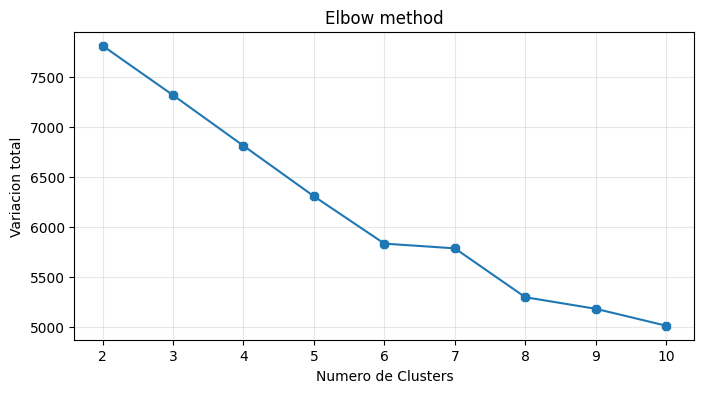

In [63]:
plt.figure(figsize=(8,4))

plt.plot(range(2, 11), Total_variation, marker='8')
plt.xlabel('Numero de Clusters')
plt.ylabel('Variacion total')
plt.title("Elbow method")
plt.grid(True, alpha=0.3)
plt.show()

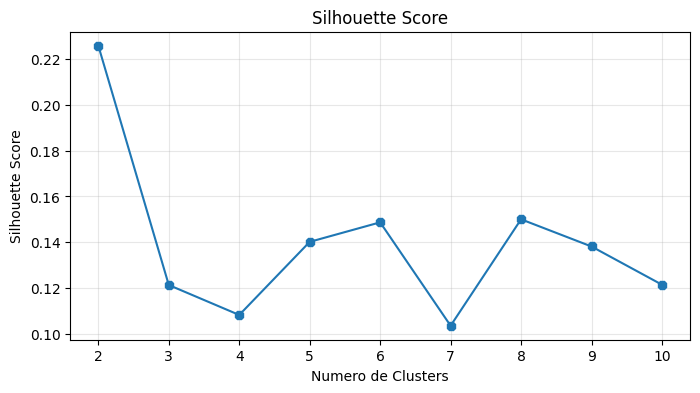

In [64]:
plt.figure(figsize=(8,4))

plt.plot(range(2, 11), Silhouette, marker='8')
plt.xlabel('Numero de Clusters')
plt.ylabel('Silhouette Score')
plt.title("Silhouette Score")
plt.grid(True, alpha=0.3)
plt.show()

In [65]:
LoopResults = pd.DataFrame(np.arange(2,11,1),columns = ['K value'])
LoopResults['Variacion total'] = Total_variation
LoopResults['Silhouette Score'] = Silhouette
print(LoopResults)

   K value  Variacion total  Silhouette Score
0        2      7813.645910          0.225825
1        3      7318.941099          0.121296
2        4      6812.538811          0.108219
3        5      6307.395193          0.140153
4        6      5833.952270          0.148683
5        7      5786.699102          0.103520
6        8      5297.930459          0.150004
7        9      5182.051491          0.138128
8       10      5012.746985          0.121438


In [66]:
from yellowbrick.cluster import SilhouetteVisualizer

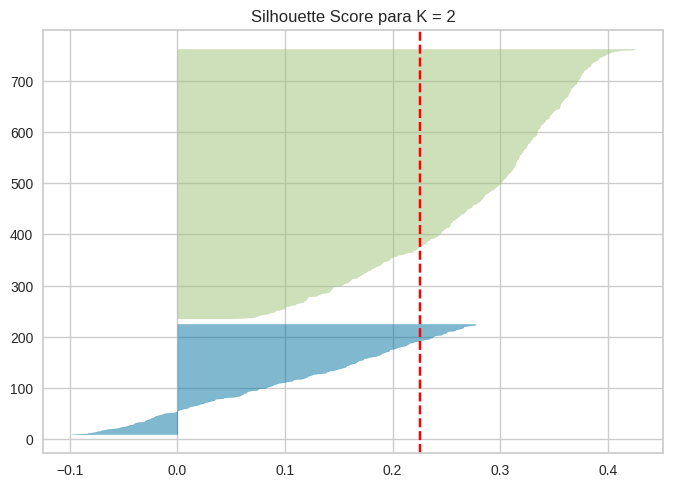

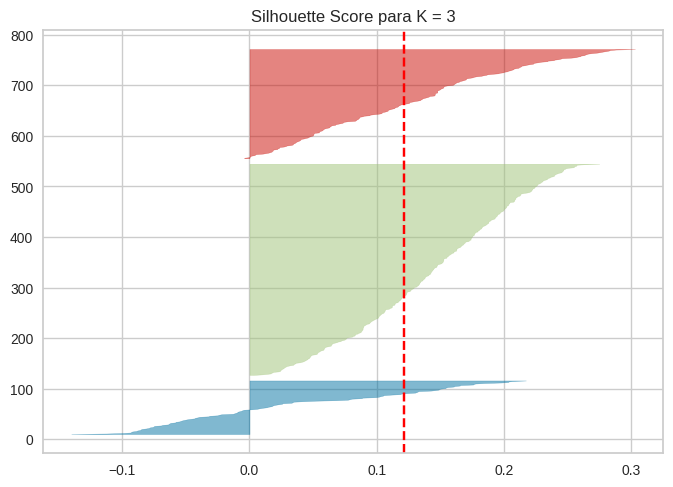

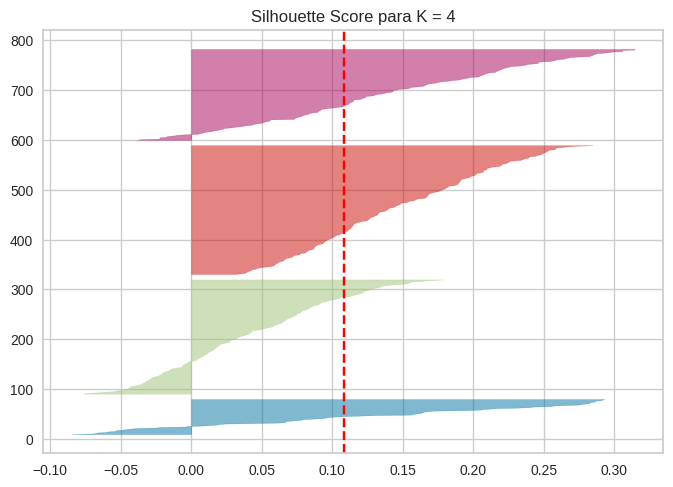

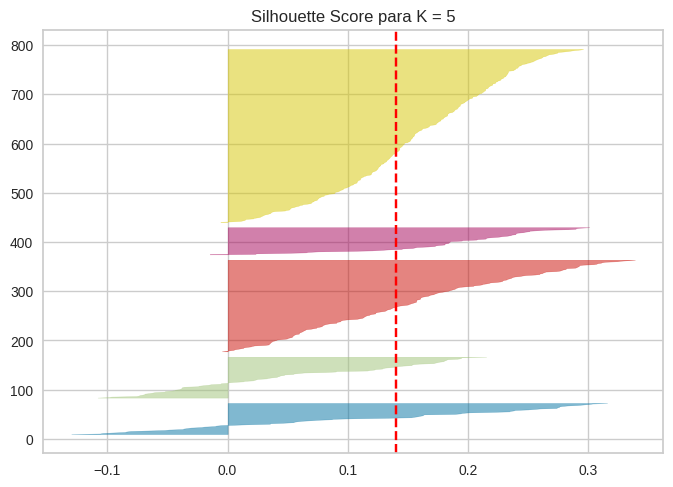

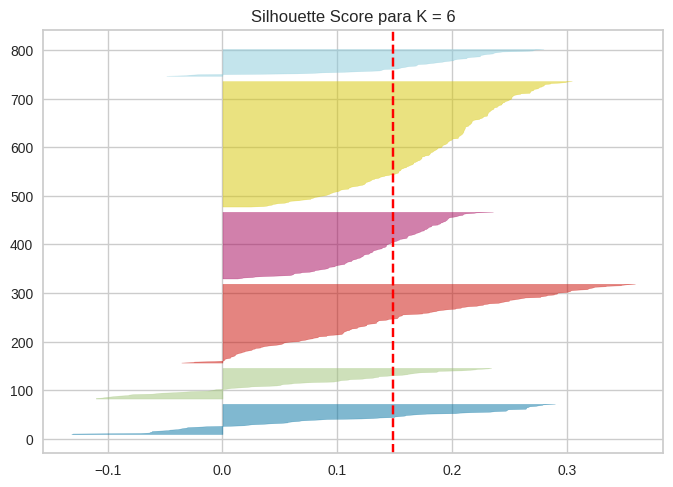

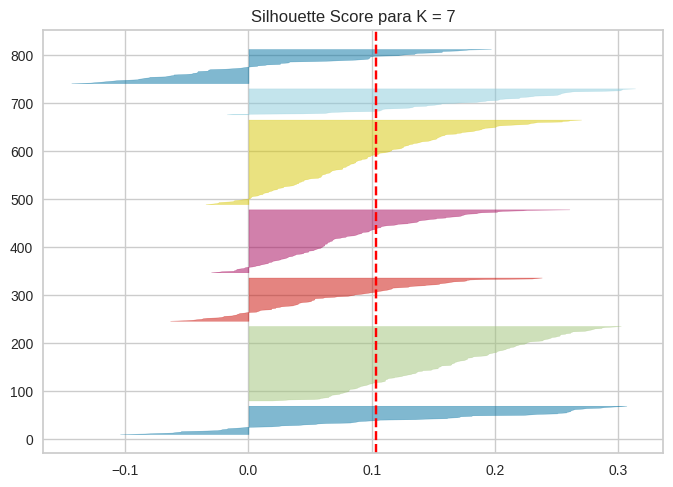

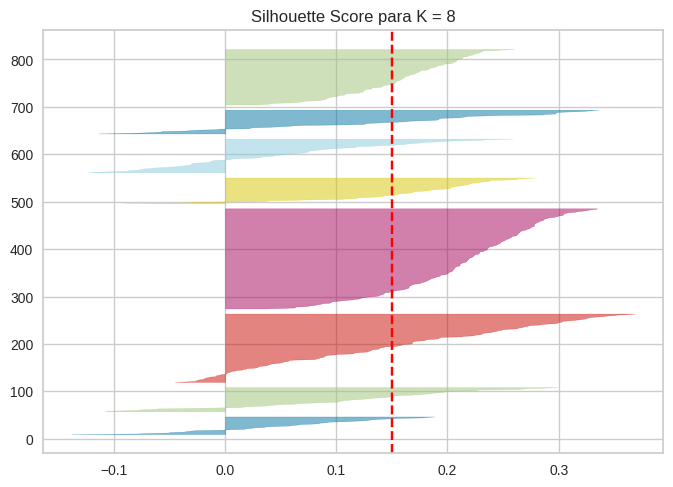

In [67]:
for k in range (2,9):
  model = KMeans(k, random_state=42)
  visualizer = SilhouetteVisualizer(model, colors='yellowbrick')
  visualizer.set_title(f"Silhouette Score para K = {k}")
  visualizer.fit(final_df)
  plt.show()